In [1]:
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

trainDataset = torchvision.datasets.FashionMNIST("fashionDataset", train=True, download=True, transform=transforms.ToTensor())


x,y = trainDataset[0]
print(y)

cuda
9


In [8]:
class CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 3, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(3, 9, kernel_size=5, padding=2)
        self.conv3 = torch.nn.Conv2d(9, 20, kernel_size=5, padding=2)
        self.conv4 = torch.nn.Conv2d(20, 25, kernel_size=5, padding=2)
        self.fc1 = torch.nn.Linear(225, 100)
        self.fc2 = torch.nn.Linear(100, 10)
        self.drop = torch.nn.Dropout(0.20)
        self.pool = torch.nn.MaxPool2d(2, 2) #Halfs image

        self.conv = torch.nn.Sequential(
            self.pool,
            torch.nn.ReLU()
        )
    
    def forward(self, x):

        x = self.conv(self.conv1(x))
        x = self.conv(self.conv2(x))
        x = self.conv(self.conv3(x))
        x = torch.nn.functional.relu(self.conv4(x))
        x = x.reshape((-1, 225))
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    
model = CNN()
model.to(device)





CNN(
  (conv1): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(3, 9, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(9, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(20, 25, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=225, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (drop): Dropout(p=0.2, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): ReLU()
  )
)

In [11]:
epochs = 20
batchSize = 600
dataloader = DataLoader(trainDataset, batch_size=batchSize, shuffle=True, num_workers=4)


loss = torch.nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.5e-3, weight_decay=1e-6)




In [12]:
from IPython.display import clear_output

history = []
accuracy = []
model.train()
for i in range(epochs):
    totalCost = 0
  
    for xBatch, yBatch in dataloader:
        optimiser.zero_grad()
        xBatch = xBatch.to(device)
        yBatch = yBatch.to(device)
        
        y_this = model(xBatch)

        cost = loss(y_this, yBatch)
        cost.backward()
        totalCost += cost.item()

        optimiser.step()
    ##Plot acc
    ySet = trainDataset.targets.to(device)
    xSet = trainDataset.data.reshape(-1, 1, 28, 28)
    xSet = xSet.to(device).to(torch.float)
    modelOutput = model(xSet)

    indexOut = torch.argmax(modelOutput, dim=1)
    matches = indexOut == ySet
    accuracy.append(matches.sum().item()*100/len(ySet))

    plt.figure(figsize=(6,3))
    plt.plot(accuracy)
    plt.show()
    print(i)
    clear_output(wait=True)

    history.append(totalCost/len(trainDataset))
plt.plot(history)
plt.show()



KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), "modelParams.pt")

torch.float32


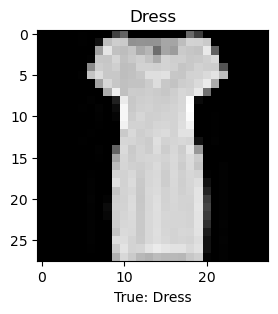

In [5]:
model.eval()
labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
testImage, expectedOutput = trainDataset[20]
print(testImage.dtype)
modelOutput = model(testImage.to(device))
index = torch.argmax(modelOutput[0], dim=0).item()

plt.figure(figsize=[6,3])
plt.title( labels[index])
plt.xlabel("True: "+labels[expectedOutput])
plt.imshow(testImage[0], cmap="gray")



In [6]:
##Test Entire ds for accuracy
model.eval()
ySet = trainDataset.targets.to(device)
xSet = trainDataset.data.reshape(-1, 1, 28, 28)
xSet = xSet.to(device).to(torch.float)
modelOutput = model(xSet)

indexOut = torch.argmax(modelOutput, dim=1)
matches = indexOut == ySet
print(matches.sum().item()*100/len(ySet))


83.355


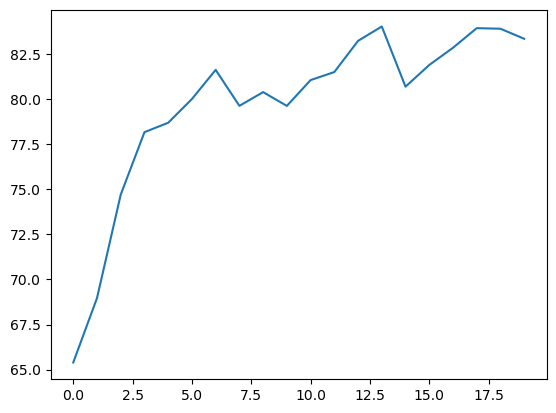

In [7]:
plt.plot(accuracy)
plt.show()

In [ ]:
model.load_state_dict(torch.load("modelParams.pt"))